# Simulating Predator and Prey Relationship : Event-based

This is our most accurate model. It is also the most compute-intensive.  Each animal is represented by an object with a birthdate and a gender.  Every reproduction involves two events -- a mating event and a childbirth event.  Every animal will eventually die of old age -- this is an event that is created when the animal is born.

## Part 1: Rabbits without predators

This simulation uses the earlier assumptions that a rabbit eats six square feet of pasture per day and a coyote's metabolism burns one rabbit per day. Once again, this simulation occurs in a five acre clearing in a forest: about 218,000 square feet. We will assum that the pasture grows 3,630 square feet worth of new grass each day.

In the presence of at least one male, a female rabbits reproduce about six times per year. They have six to ten children in a litter.  According to [Wikipedia](https://en.wikipedia.org/wiki/Rabbit), a wild rabbit reaches sexual maturity when it is about six months old and typically lives one to two years.

Let's create an event-based simulation of the population of rabbits (no predators) with all of this taken into account. Here are the data structures and algorithms:

In [1]:
import sys
import random

class Event(object):

    def __init__(self, day):
        self.id = 0
        self.day = day

    def __lt__(self, other):
        return self.day < other.day

    def execute(self, world):
        sys.stderr.write('*** Error: Override execute in {} ***'.format(self))
        pass

import datetime

def str_for_day(day):
    delta = datetime.timedelta(days=day)
    d = datetime.date.today() + delta
    return d.strftime('%Y-%b-%d')

class RabbitNaturalDeathEvent (Event):
    def __init__(self, day, rabbit):
        super().__init__(day)
        # print("Rabbit {} scheduled to die {}", rabbit, str_for_day(day))
        self.rabbit = rabbit

    def execute(self, world):
        global rabbits
        world.remove_event(self.rabbit.mate_handle)
        world.remove_event(self.rabbit.birth_handle)
        rabbits.remove(self.rabbit)

class RabbitMateEvent (Event):
    def __init__(self, day, rabbit):
        super().__init__(day)
        self.rabbit = rabbit

    def execute(self, world):
        if has_male_rabbits():
            birth_day = current_day + 45
            self.chilbirth_handle = world.add_event(RabbitBirthEvent(birth_day, self.rabbit))

class RabbitBirthEvent (Event):
    def __init__(self, day, rabbit):
        super().__init__(day)
        self.rabbit = rabbit

    def execute(self, world):
        global rabbits
        mate_day = current_day + 15 # 15 days rest before mating again
        self.mate_handle = world.add_event(RabbitMateEvent(mate_day, self.rabbit))
        baby_count = random.randint(6,10)
        for i in range(baby_count):
            rabbits.append(Rabbit(world, random.random() < 0.5))
            
            
class Rabbit(object):
    def __init__(self, world, is_female):
        self.is_female = is_female
        self.birthdate = current_day
        natural_death_date = current_day + int(365.0 + random.random() * 365.0)
        self.natural_death_handle = world.add_event(RabbitNaturalDeathEvent(natural_death_date, self))
        
        if self.is_female:
            sexual_maturity_date = current_day + int(100.0 + random.random() * 40.0)
            self.mate_handle = world.add_event(RabbitMateEvent(sexual_maturity_date, self))
        else:
            self.mate_handle = -1
        self.birth_handle = -1

    def __repr__(self):
        if (self.is_female):
            return 'Female rabbit: {}'.format(str_for_day(self.birthdate))
        else:
            return 'Male rabbit: {}'.format(str_for_day(self.birthdate))
        
def has_male_rabbits():
    for r in rabbits:
        if not r.is_female:
            return True
    return False


def feed_rabbits(world):
    global rabbits, grass
    unfed_rabbits = rabbits.copy()
    #sys.stderr.write('Trying to feed {} with {}\n'.format(len(rabbits), grass))
    # Feed as many as you can
    while len(unfed_rabbits) > 0 and grass > grass_per_rabbit_day:
        r_indx = random.randrange(0, len(unfed_rabbits))
        grass = grass - grass_per_rabbit_day
        del unfed_rabbits[r_indx]
            
    # Kill off the rest
    while len(unfed_rabbits) > 0:
        rabbit = unfed_rabbits[0]
        rabbits.remove(rabbit)
        world.remove_event(rabbit.natural_death_handle)
        world.remove_event(rabbit.mate_handle)
        world.remove_event(rabbit.birth_handle)
        del unfed_rabbits[0]
        # sys.stderr.write('Grass remaining {}\n'.format(grass))
        
def create_initial_rabbits(world):
    # Starting rabbits
    for i in range(200):
        rabbits.append(Rabbit(world, random.random() < 0.5))

# Update the day (may need to update world state)
def grow_grass(self):
    global grass
        
    grass = grass + 3630
    if grass > 218000:
        grass = 218000

import heapq as q

class World:

    def __init__(self):
        
        # Managed by heap methods: heappush, etc.
        self.queue = []

        # To loop up events for removal
        self.event_index = {}

        # To create unique event handles for possible removal
        self.next_event_id = 1


    # Adds event to queue and returns handle for removal
    def add_event(self, event):
        eid = self.next_event_id
        event.id = eid
        self.next_event_id = self.next_event_id + 1
        q.heappush(self.queue, event)
        self.event_index[eid] = event
        return eid

    # Takes event handle
    def remove_event(self, eid):
        if eid in self.event_index:
            event = self.event_index[eid]
            self.queue.remove(event)
            del self.event_index[eid]

    # Are there more events to execute?
    def has_events(self):
        return len(self.queue) > 0
                

    # Update the day (may need to update world state)
    def update_for_day(self):
        global current_day, grass
        
        current_day += 1
        # sys.stderr.write('{},{}\n'.format(str_for_day(current_day), len(rabbits)))

        grow_grass(world)
        feed_rabbits(world)

    # Execute one day worth of events
    def process(self, stats):
        stats[current_day, 0] = grass
        stats[current_day, 1] = len(rabbits)
        stats[current_day, 2] = len(coyotes)
        # sys.stderr.write('{},{},{}\n'.format(current_day, grass, len(rabbits)))

        self.update_for_day()
        
        while len(self.queue) > 0 and self.queue[0].day <= current_day:
            next_event = q.heappop(self.queue)
            eid = next_event.id
            del self.event_index[eid]
            next_event.execute(self)
        

Now we initialize the data, run the event loop, and chart the results:

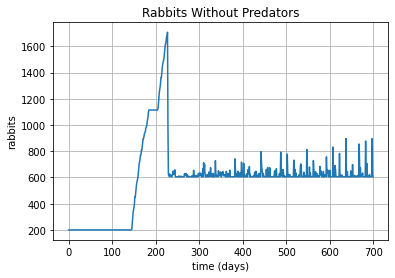

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
world = World()
                
current_day = 0
        
# A lightly grazed meadow
grass = 100000
rabbits = []
coyotes = []
grass_per_rabbit_day = 6

create_initial_rabbits(world)
        
total_days = 700
stats = np.zeros((total_days, 3))
while current_day < total_days:
    world.process(stats)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stats[:,1])
ax.set(xlabel='time (days)', ylabel='rabbits',
       title='Rabbits Without Predators')
ax.grid()



Note that as the simulation becomes more realistic, the world isn't as gentle as the differential equations would make us think.  The rabbits are reproducing frantically just as the caloric reserve in the previously lightly grazed meadow runs out.  There is a huge die-off toward equilibrium.

## Part 3: Interaction Between Coyotes and Rabbit

A coyote burns one rabbit worth of calories in a day. When a coyote has two rabbits in his stomach, it can't eat any more.  A coyote doesn't mate unless he/she has at least one rabbit in his stomach. Coyotes with less than -7 rabbits in its stomach dies for sure.  A coyote with negative rabbits feels weak and has a 1/100 chance of dying on a particular day. Pregnant coyotes with -3 rabbits stop being pregnant. 

The gestation period for a coyote is 60 to 63 days. Easter Coyotes reach sexual maturity in about 700 days. They have an average litter size of six. https://en.wikipedia.org/wiki/Coyote A well-fed coyote lives six to eight years in the wild. https://www.coyotesmarts.org/coyotes101/

Here are the data structures for that.  We have subclassed the World from the previous example to extend it to include coyotes.

In [6]:
class CoyoteNaturalDeathEvent (Event):
    def __init__(self, day, coyote):
        super().__init__(day)
        self.coyote = coyote

    def execute(self, world):
        global coyotes
        world.remove_event(self.coyote.mate_handle)
        world.remove_event(self.coyote.birth_handle)
        coyotes.remove(self.coyote)

class CoyoteMateEvent (Event):
    def __init__(self, day, coyote):
        super().__init__(day)
        # sys.stderr.write('Create mate event:{}\n'.format(day))
        self.coyote = coyote

    def execute(self, world):
        # sys.stderr.write('Thinking about mating')
        if self.coyote.unburned_rabbits > 0 and has_male_coyote():
            # sys.stderr.write('Mated!\n')
            birth_day = current_day + 60
            self.chilbirth_handle = world.add_event(CoyoteBirthEvent(birth_day, self.coyote))
        else: # Try again in a week
            # sys.stderr.write('Meh. Not today.\n')
            mate_day = current_day + 7
            self.mate_handle = world.add_event(CoyoteMateEvent(mate_day, self.coyote))

class CoyoteBirthEvent (Event):
    def __init__(self, day, coyote):
        super().__init__(day)
        self.coyote = coyote

    def execute(self, world):
        global coyotes
        mate_day = current_day + 45 # 45 days rest before mating again
        self.mate_handle = world.add_event(CoyoteMateEvent(mate_day, self.coyote))
        baby_count = random.randint(4,8)
        for i in range(baby_count):
            new_coyote = Coyote(world, random.random() < 0.5)
            coyotes.append(new_coyote)
            if new_coyote.is_female:
                sexual_maturity_date = current_day + int(500.0 + random.random() * 200.00)
                self.mate_handle = world.add_event(CoyoteMateEvent(sexual_maturity_date, new_coyote))
            
class CoyoteArrivalEvent (Event):
    def __init__(self, day, is_female):
        super().__init__(day)
        self.is_female = is_female

    def execute(self, world):
        global coyotes   
        new_coyote = Coyote(world, self.is_female)
        coyotes.append(new_coyote)
        if new_coyote.is_female:
            mate_day = current_day + int(10.0 + random.random() * 10.0)
            new_coyote.mate_handle = world.add_event(CoyoteMateEvent(mate_day, new_coyote))
            
class Coyote(object):
    def __init__(self, world, is_female):
        self.is_female = is_female
        self.birthdate = current_day
        self.unburned_rabbits = 0
        natural_death_date = current_day + int(365.0 + random.random() * 365.0)
        self.natural_death_handle = world.add_event(CoyoteNaturalDeathEvent(natural_death_date, self))
        self.mate_handle = -1
        self.birth_handle = -1

    def __repr__(self):
        if (self.is_female):
            return 'Female coyote: {}'.format(str_for_day(self.birthdate))
        else:
            return 'Male coyote: {}'.format(str_for_day(self.birthdate))
        
def has_male_coyote():
    for c in coyotes:
        if not c.is_female:
            return True
    return False

def feed_coyotes(world):
    global rabbits, grass, coyotes
    
    for c in coyotes:
        c.unburned_rabbits = c.unburned_rabbits - 1
    
    unfull_coyotes = coyotes.copy()
    # Feed as many as you can
    # There are always 50 rabbits hiding where they can't be found
    while len(rabbits) > 50 and len(unfull_coyotes) > 0:
        c_indx = random.randrange(0, len(unfull_coyotes))
        r_indx = random.randrange(0, len(rabbits))
        rabbit = rabbits[r_indx]
        del rabbits[r_indx]
        world.remove_event(rabbit.natural_death_handle)
        world.remove_event(rabbit.mate_handle)
        world.remove_event(rabbit.birth_handle)
        coyote = unfull_coyotes[c_indx]
        coyote.unburned_rabbits = coyote.unburned_rabbits + 1
        if coyote.unburned_rabbits >= 2:
            del unfull_coyotes[c_indx];

    # Deal with coyote hunger
    doomed_coyote_indices = []
    for i in range(len(coyotes)):
        coyote = coyotes[i]
        if coyote.unburned_rabbits <= -8:
            # print("Coyote dies from hunger")
            doomed_coyote_indices.append(i)
        elif coyote.birth_handle > 0 and coyote.unburned_rabbits <= -3:
            # print("Coyote miscarries")
            world.remove_event(coyote.birth_handle)
            coyote.birth_handle = -1
        elif coyote.unburned_rabbits < 0 and random.random() < 0.01:
            # print("Weakened coyote dies")
            doomed_coyote_indices.append(i)

    for i in reversed(doomed_coyote_indices):
        coyote = coyotes[i]
        world.remove_event(coyote.natural_death_handle)
        # print("Removing mate_handle")
        world.remove_event(coyote.mate_handle)
        world.remove_event(coyote.birth_handle)
        del coyotes[i]
 
        
def create_initial_coyotes(world):
    # Schedule a male and female to show up
    world.add_event(CoyoteArrivalEvent(200, False));
    world.add_event(CoyoteArrivalEvent(210, True));


class CoyoteWorld (World):

    # Update the day (may need to update world state)
    def update_for_day(self):
        global current_day, grass
        
        current_day += 1
        #sys.stderr.write('{},{},{},{}\n'.format(current_day, grass, len(rabbits), len(coyotes)))

        grow_grass(world)
        feed_rabbits(world)
        feed_coyotes(world)



Now we initialize the data, run the event loop, and plot the results: (This may take 30 seconds to run.)

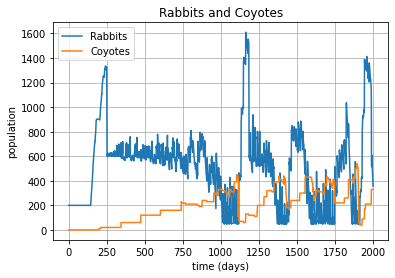

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
world = CoyoteWorld()
                
current_day = 0
        
# A lightly grazed meadow
grass = 100000
rabbits = []
coyotes = []
grass_per_rabbit_day = 6

create_initial_rabbits(world)
create_initial_coyotes(world)
        
total_days = 2000
stats = np.zeros((total_days, 3))
while current_day < total_days:
    world.process(stats)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stats[:,1], label ='Rabbits')
ax.plot(stats[:,2] * 10, label = 'Coyotes')
ax.set(xlabel='time (days)', ylabel='population',
       title='Rabbits and Coyotes')
ax.legend()
ax.grid()